In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm

%matplotlib inline

### Job Submission

In [ ]:
#job submission

#dry run
from make_runlist_new import write_spe_lists

write_spe_lists(write=False)

In [ ]:
#writes actual runlists

written=write_spe_lists(write=True)

In [ ]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % os.path.join('runlists', file)
    print(command)
    !{command}

In [ ]:
#submit jobs for new runlists
for f in written:
    submit_job(f)

### Acc vs Time Plot

In [2]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [3]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

In [21]:
# acc for just two runlists

runlists = ['runlist_10610_10611_10612.txt','runlist_8840_8841_8842.txt','runlist_12211_12213_12214.txt']

#all runlists
#runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
accs = []
upper_errs=[]
lower_errs=[]
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'rb') as cd:
    if os.stat('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl').st_size==0:
        data=[]
    else:
        data=pickle.load(cd)
saved_runlists=[]

for cd in data:
    saved_runlists.append(cd.runlist)
    
    runlist = file_to_list(f)
            
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    acc=cd.acc
    acc_errs_l=cd.acc_errs_l
    acc_errs_u=cd.acc_errs_u
    acc_sys=cd.acc_sys
    acc_stat=cd.acc_stat
    occ=cd.occ
    occ_sys=cd.occ_sys
    occ_stat=cd.occ_stat
    
    accs.append(np.mean(acc))
    lower_errs.append(np.mean(acc_errs_l**2))
    upper_errs.append(np.mean(acc_errs_u**2))
    bottom_runs.append(bottom_run)
            

for f in tqdm(sorted(runlists)):
    if f in saved_runlists:
        print("Data already exists for: ", f)
        continue
        
    else:
        runlist = file_to_list(f)
        if not all_data_exists(runlist):
            resubmit_files.append(f)
            #print('data missing for %s' % f)
            for r in runlist:
                if not data_exists(r):
                    missing_runs.append(r)
            continue
        
    
        bottom_run = runlist[0]
        topbulk_run = runlist[1]
        topring_run = runlist[2]
        
        thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
        
        acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
        occ, occ_sys, occ_stat = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
        on_channels = np.where(occ > 0.05)[0]
    
        if len(on_channels) < 200:
            LED_off.append(f)
            #print('LED likely OFF for %s' % f)
            continue
        
        acc = acc[on_channels]
        acc_errs_l = acc_errs[0]
        acc_errs_u = acc_errs[1]
        accs.append(np.mean(acc))
        lower_errs.append(np.mean(acc_errs_l**2, axis=0)[0])
        upper_errs.append(np.mean(acc_errs_u**2, axis=0)[0])
        bottom_runs.append(bottom_run)
        cd=analyze.ch_data(f, get_run_time(bottom_run), acc, acc_errs_l, acc_errs_u, acc_sys, acc_stat, occ, occ_sys, occ_stat )
        data.append(cd)

os.remove('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl')
with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'wb') as f:
    pickle.dump(data, f)
    
errors=np.array([lower_errs, upper_errs])
print(errors)
print(len(accs))
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

100%|██████████| 2/2 [00:00<00:00, 308.77it/s]

Data already exists for:  runlist_10610_10611_10612.txt
Data already exists for:  runlist_8840_8841_8842.txt
[[ 0.0048189   0.00420752  0.00341539  0.0048189   0.00420752  0.00341539]
 [ 0.00480496  0.00421538  0.0033677   0.00480496  0.00421538  0.0033677 ]]
6
These runs are missing data:  []
LED likely off for these files:  []


/home/awalsh272/SPE/SPE/analyze.py:74: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)


mu:  138.287357048
sigma:  176.749888812


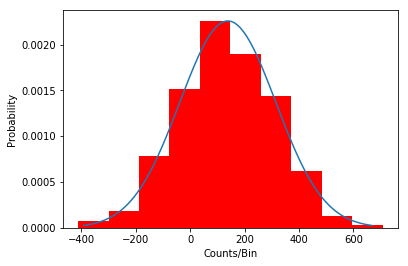

In [18]:
#check that the MC is sampling correctly
path = os.path.join(data_dir_base, 'run_%05d.h5' % 10610)
s=analyze.SPE(path)
residual, sigma_res= s.residual(6,'amplitude')
mu=residual[176][106]
sigma=sigma_res[176][106]
print('mu: ',mu)
print('sigma: ',sigma)
x=np.linspace(mu-3*sigma, mu+3*sigma, num=1000)
plt.figure()
gauss=norm(loc=mu, scale=sigma)
r=norm.rvs(loc=mu, scale=sigma, size=1000)
plt.plot(x, gauss.pdf(x))
plt.xlabel('Counts/Bin')
plt.ylabel("Probability")
plt.hist(r, color='r', normed="True")
plt.show()

In [ ]:
#get noise rms for acc vs time plot
#explains outliers 

noise_runs = []
noise_rms = []
noise_errors = [[],[]]

with open('./noise_rms.csv') as f:
    for num, line in enumerate(f.readlines()):
        if num==0:
            continue
        line = line.split(',')
        run, rms, lower, upper = int(line[0]), float(line[1]), float(line[2]), float(line[3])
        noise_runs.append(run)
        noise_rms.append(rms)
        noise_errors[0].append(lower)
        noise_errors[1].append(upper)
        
noise_dates = [get_run_time(run) for run in noise_runs]

In [ ]:
#plot acceptance vs time 

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

bottom_runs = np.array(bottom_runs)
print('bottom_runs: ',bottom_runs)
dates = np.array([get_run_time(run) for run in bottom_runs])

accs = np.array(accs)
errors = np.array(errors)
print(errors)

noisy_runs = [12768, 13837]

sr1 = np.where(bottom_runs > 6731)
print(sr1, sr1[0])
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]

plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = [errors[0][sr1],errors[1][sr1]]
print(plot_errors)
print(accs)

f, ax = plt.subplots(figsize=(12,8))
#plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('data')
ax.set_ylabel('spe acceptance')

ax2 = ax.twinx()
ax2.scatter(noise_dates, noise_rms, color='red')
ax2.tick_params('y', colors='red')
ax2.set_ylabel('noise rms', color='red')
ax2.set_ylim(1.8,3.8)
plt.savefig('new_moneyplot.png')
plt.show()

### Resubmit jobs without all needed data

In [ ]:
#submits jobs that didn't work the first time
for f in resubmit_files:
    submit_job(f)